In [ ]:
## IMPORTANT: On Colab, we expect your homework to be in the cs189 folder
## Please contact staff if you encounter any problems with installing dependencies
import sys
IS_COLAB = 'google.colab' in sys.modules
if IS_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/MyDrive/cs189/hw/hw2
    %pip install -r ./requirements.txt
    !pip install -U kaleido plotly
    import kaleido
    kaleido.get_chrome_sync()

import plotly.io as pio
pio.renderers.default = pio.renderers.default + "+png"

In [ ]:
# Initialize Otter
import otter
grader = otter.Notebook("arena_style_control.ipynb")

<link rel="stylesheet" href="berkeley.css">

<h1 class="cal cal-h1">Homework 02 – Welcome to the Arena (Style Control)</h1>

CS 189, Fall 2025

In this homework you will get more experience with logistic regression to create model leaderboards.

We will be taking real data from [LMArena](https://lmarena.ai/), a popular platform for crowdsourcing evaluations of large language models and recreating their leaderboards, with a few fun extra steps along the way.

The chats can be viewed interactively by accessing [ChatBot-Arena-Viewer](https://huggingface.co/spaces/BerkeleyML/Chatbot-Arena-Viewer) through hugging face. Much of the first half of this homework was first written by Prof Gonzalez back when his students first started the project, and now LMArena is a standard evaluation for large language models and turned into a company! Don't let anyone tell you logistic regression isn't valuable, it's worth at least $600 Million.
    
---


## Due Date: Friday, October 17, 11:59 PM

This assignment is due on **Friday, October 17, 11:59 PM**. You must submit your work to Gradescope by this deadline. Please refer to the syllabus for the [Slip Day policy](https://eecs189.org/fa25/syllabus/#slip-days). No late submissions will be accepted beyond the details outlined in the Slip Day policy.

### Submission Tips
- **Plan ahead**: We strongly encourage you to submit your work several hours before the deadline. This will give you ample time to address any submission issues.
- **Reach out for help early**: If you encounter difficulties, contact course staff well before the deadline. While we are happy to assist with submission issues, we cannot guarantee responses to last-minute requests.
      
<!-- --- -->

### Key Learning Objectives

In this homework you will build on the previous warmup section, implementing the Bradley-Terry ranking used in the actual Arena and taking account of style controls for model rank. In particular, you will:
1. Apply the Bradley–Terry model to build leaderboards
2. Practice analyzing conversational data and extracting stylistic features  
3. Build custom features (length, punctuation, phrase presence, etc.) and integrate them into ranking models  
4. Explore confounding stylistic variables in LLM evaluation (style vs. content)  
5. Apply pairwise evaluation methods to understand how style affects outcomes  
  
---

### Collaboration Policy
You are encouraged to discuss high-level concepts with your peers. However:
- All submitted work must be written in your own words and code.
- Do not share or copy solutions directly.
- List any collaborators (students you worked with) in the line below:

**Your Collaborators**: **I don't have a collaborator**

### AI Tools Usage Disclosure
We allow the use of AI tools (e.g., ChatGPT, Copilot) **only as support**, not as a replacement for your own reasoning. To ensure transparency, you must acknowledge any use of AI tools.

Please complete one of the following:
- **A) I did not use any AI tools for this homework.**
- **B) I used AI tools in the following way(s):**  
  (describe briefly, e.g., “Used ChatGPT to get hints for debugging a NumPy indexing error”)


**Your Answer**: **I did not use any AI tools for this homework.**
    
---

### Grading Breakdown

| Question | Manual Grading? | Points |
|----------|-----------------|--------|
| q4a      | No              | 2      |
| q4b      | No              | 2      |
| q4c      | Yes             | 2      |
| q5a      | No              | 2      |
| q5b      | No              | 2      |
| q7a      | No              | 2      |
| q7b      | No              | 2      |
| q8a      | No              | 2      |
| q8afrq   | Yes             | 2      |
| q8b      | No              | 2      |
| q8c      | No              | 2      |
| q9a      | No              | 2      |
| q9b      | Yes             | 4      |
| q9c      | Yes             | 6      |
| **Total**|                 | **34** |


In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotting_utils import plot_rank_heatmap, plot_style_features
#set fixed seed of 189
np.random.seed(189)

In [ ]:
! pip install ipywidgets
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from datasets import load_dataset
# Login using e.g. `huggingface-cli login` to access this dataset (this will take a few minutes to download)
ds = load_dataset("lmarena-ai/arena-human-preference-100k")
battles = ds['train'].to_pandas()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



README.md: 0.00B [00:00, ?B/s]

data/arena-explorer-preference-100k.parq(…):   0%|          | 0.00/380M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/106134 [00:00<?, ? examples/s]

## Initialize with HW2 Warmup

Fill in the cells in this section with your implementations from part 1 of the homework.

#### FILL IN: HW2 Part 1 Question 1B Block

In [ ]:
# #TODO: FILL IN from your solution for Question 1B
models = pd.concat([battles["model_a"], battles["model_b"]])
selected_models = models.value_counts().head(20).index.to_list()
selected_battles = battles[(battles.model_a.isin(selected_models)) & (battles.model_b.isin(selected_models))]
selected_battles_no_ties = selected_battles[(selected_battles.winner != 'tie') & (selected_battles.winner != 'tie (bothbad)')]

In [ ]:
print("Before dedup: ", len(selected_battles_no_ties))
selected_battles_no_ties = selected_battles_no_ties[selected_battles_no_ties["dedup_tag"].apply(lambda x: x.get("sampled", False))]
print("After dedup: ", len(selected_battles_no_ties))

Before dedup:  26154
After dedup:  25533


##  **Question 4: Model Strengths**

In the earlier part of the homework, we calculated the Average Model Win-Rate.

However, this method is not ideal for our use case where battle counts per model are not equal. For instance, if ChatGPT-4o-latest battled more often with weaker models, it would have a high win rate without being an actually stronger model. Now let's explore how we can instead *learn* these model strengths.

**To recap,** we want to construct a leaderboard by assigning a strength score $S_m$ to each model $m \in \{1,...,M\}$, such that:
- The ranking reflects the probability of one model winning against another.
- For any pair of models A and B, the probability that A beats B, should depend on the *difference* in their strengths: $S_A - S_B$. Why the difference? Since we are measuring pairwise preference, there is no absolute measure of strength but rather a model's strength *relative* to other models.

**Formally, we want a function $f$ such that**
- For models A and B with scores $S_A$ and $S_B$, we want:
  $$ P(\text{A beats B}) = f(S_A - S_B) $$
- The function $f$ should be increasing (bigger skill gap, higher win chance), and always output a probability between 0 and 1.

At this point, a natural question is: what should we choose for the function $f$? A standard and effective choice is the logistic (sigmoid) function:

$$ P(\text{A beats B}) = \sigma(S_A - S_B) = \frac{1}{1 + e^{-(S_A - S_B)}} $$

Notice that this is exactly the same form as logistic regression, where the model scores are the parameters to be learned. In other words, learning model strengths from pairwise outcomes is equivalent to fitting a logistic regression model to the data.

So, we can use logistic regression to learn the model strengths that best explain the observed battle outcomes. The higher a model's score, the more likely it is to win against others. The methodology is called the [Bradley-Terry](https://en.wikipedia.org/wiki/Bradley%E2%80%93Terry_model) model and is the underlying theory to other common scoring systems like ELO ratings.

#### Step 1: Understanding the formulation of the problem as features

To learn these model strengths, we need to prepare our data in a form suitable for logistic regression. Recall that each battle involves two models: A and B. One of them wins (for simplicity we still start by removing any battles that end in ties).

We want to convert this into:

1. A feature vector indicating which two models were involved.
2. A label representing the winner.

Each row produces two training examples:

1. One with model A as +1 and model B as –1, and a label denoting if model A wins
2. Another with model B as +1 and model A as –1, and a label denoting if model B wins

Let's take a look an example:

`row = {'model_a': 'gpt-4o-2024-05-13', 'model_b': 'claude-3-opus-20240229', 'winner': 'model_a'}`

This generates two features, which are...

**Feature 1:** [1, -1]
* +1 at index 0 (gpt-4o)
* –1 at index 1 (claude-3-opus)
* Label: 1 because model A (gpt-4o) won

**Feature 2:** [-1, 1]
* -1 at index 0 (gpt-4o)
* +1 at index 1 (claude-3-opus)
* Label: 0 because model B (claude-3-opus) lost

Why do we have to do this?
This lets the model take account for both ways:


$$ P(\text{GPT-4o beats Claude-3-opus}) = \sigma(S_{\text{GPT-4o}}  - S_{\text{Claude}})$$



$$ P(\text{Claude-3-opus beats GPT-4o}) = \sigma(S_{\text{Claude}} - S_{\text{GPT-4o}}  )$$


**Think:** When we have more than two models, how should we handle the models that were not involved in the battle?

---

#### Step 2: Constructing generalized features and labels

Cool, now we want to generalize this formulation to the pair of not only GPT-4o and Claude-3-opus, but all the models.

Once we have turned all battle outcomes into feature vectors, we can organize them into a **feature matrix** $\mathbf{X}$ and a **label vector** $\mathbf{y}$.

We have the model strengths we want to learn:
\begin{bmatrix}
S_A \\
S_B \\
S_C
\end{bmatrix}

And we want our model to predict:

\begin{bmatrix}
\sigma(S_A - S_C) \\
\sigma(S_B - S_A) \\
\sigma(S_B - S_C)
\end{bmatrix}



As a recap...

- $\mathbf{X}$ encodes **who played whom** and in what direction.
- $\mathbf{S}$ are the model strengths we are trying to learn.
- $\mathbf{y} = \sigma(\mathbf{X} \cdot \mathbf{S})$ gives us the predicted win probabilities.

Now let's try to actually featurize these battles and labels!

## **Question 4a**

In order to train our model, we should first featurize our battles as discussed before.

**Task:** Implement the function below to transform `selected_battles_no_ties` and `selected_models` into feature vectors and labels. This will allow us to represent each battle as input-output pairs for training.

In [ ]:
def turn_into_features(df, models):
    '''
    Convert pairwise battle results into feature matrix X and label vector y
    suitable for logistic regression based on the Bradley-Terry model
    '''
    # TODO:
    # 1. Iterate through each row in the DataFrame.
    # 2. For each battle, create a feature vector:
    #    - Assign +1 to the column corresponding to 'model_a'.
    #    - Assign -1 to the column corresponding to 'model_b'.
    #    - All other columns should be 0.
    # 3. Append the label:
    #    - 1 if 'model_a' is the winner.
    #    - 0 if 'model_b' is the winner.
    # 4. Return the feature matrix X and label vector y as numpy arrays.
    model_a = np.array(df.model_a)
    model_b = np.array(df.model_b)
    win = np.array(df.winner)
    X = []
    y = []
    for i in range(len(model_a)):
      vec_1 = np.zeros(20)
      vec_2 = np.zeros(20)
      a_index = np.where(np.array(models) == model_a[i])[0][0]
      b_index = np.where(np.array(models) == model_b[i])[0][0]

      vec_1[a_index] = 1.0
      vec_1[b_index] = -1.0
      vec_2[a_index] = -1.0
      vec_2[b_index] = 1.0

      if win[i] == "model_a":
        y += [1, 0]
      else:
        y += [0, 1]

      X += [vec_1, vec_2]

    return np.array(X), np.array(y)

X, y = turn_into_features(selected_battles_no_ties, selected_models)
X.shape, y.shape

((51066, 20), (51066,))

In [ ]:
grader.check("q4a")

q4a results: All test cases passed!

## **Question 4b**
Now that we have extracted out the features from the previous question, let's now dive into actually building the model. Note that for Bradley-Terry logistic regression, we do *not* want an intercept in your model.

**Task:**
Train the model with the features and labels created in Question 4a, and store the strengths, sorted in the order of scores in `results_df`.

In [ ]:
from sklearn.linear_model import LogisticRegression


model = LogisticRegression(fit_intercept=False).fit(X, y)
scores = model.coef_[0]

results = {"Model": selected_models, "Score": scores}
results_df = pd.DataFrame(results).sort_values("Score", ascending=False).reset_index(drop=True)
results_df

,Model,Score
0,chatgpt-4o-latest,0.762696
1,gemini-1.5-pro-exp-0801,0.567295
2,gpt-4o-2024-05-13,0.423263
3,gpt-4o-mini-2024-07-18,0.394791
4,gpt-4o-2024-08-06,0.326973
5,llama-3.1-405b-instruct,0.310571
6,claude-3-5-sonnet-20240620,0.295533
7,llama-3.1-70b-instruct,0.190089
8,gemini-1.5-pro-api-0514,0.181034
9,gpt-4-turbo-2024-04-09,0.175324


In [ ]:
grader.check("q4b")

q4b results: All test cases passed!

<!-- BEGIN QUESTION -->

## **Question 4c**

Let's think about an important aspect of our formulation.

**Task:** Answer the following question: Why we don't need an intercept for the logistic regression formulation above?

YOUR ANSWER: The reason we do not need an intercept is that the input to the logistic regression is the difference between the performance scores of two models, not the scores themselves. If an intercept were included, it would shift all comparisons by a constant amount, introducing bias and distorting the relative difference between the two models, which would make the results inaccurate.

<!-- END QUESTION -->

# **Question 5: Confidence Intervals**

From the previous question, we were able to train the model and obtain the scores of the models.

However, when comparing model scores, it's important to understand not just the average performance, but also how much uncertainty there is in our estimates. Our rankings are based on a finite sample of battles, and if we had collected a different set of match-ups, the resulting scores could be different. This sampling variability means that our estimated model strengths are subject to noise.

Bootstrapping is a powerful, intuitive way to assess this uncertainty without making strong assumptions about the underlying data. By repeatedly resampling our observed battles (with replacement) and retraining the model on each resampled dataset, we simulate what might have happened if we had observed a slightly different set of battles. For each resample, we get a new set of model scores. By looking at the distribution of these bootstrapped scores, we can estimate confidence intervals for each model's strength.

In short, bootstrapping helps us answer: "If we repeated this evaluation process many times, how much could each model's score vary just due to random chance in which battles we happened to observe?" This gives us a more honest sense of which differences in model scores are robust, and which might just be due to luck.

## **Question 5a**

Let's implement a function that returns these scores and confidence intervals after bootstrapping.

**Task:**
* Bootstrap the samples to train a new logistic regression model.
* Store each set of coefficients (or learned model strengths).
* Compute the mean and percentiles (2.5th and 97.5th) to obtain the 95% confidence intervals.
* Return i) results_df, ii) mean_scores, iii) confidence_intervals

An example outout of results_df is below.

| Model                   | Average Score | Lower Bound | Upper Bound | Category | Rank |
|-------------------------|--------------:|------------:|------------:|----------|-----:|
| chatgpt-4o-latest       |     0.888888  |   0.777777  |   0.999999  | Overall  |    1 |
| gemini-1.5-pro-exp-0801 |     0.777777  |   0.666666  |   0.888888  | Overall  |    2 |


In [ ]:
def get_bootstrapped_score(X, y, models, category_name="Overall", n_bootstrap=10):
    """
    Bootstraps logistic regression model scores to estimate confidence intervals.
    Args:
        X: Feature matrix
        y: Labels
        models: List of model names (order matches columns of X)
        n_bootstrap: Number of bootstrap samples
    Returns:
        results_df: DataFrame with Model, Average Score, Lower Bound, Upper Bound
        mean_scores: Mean of bootstrapped scores (np.array)
        confidence_intervals: 2.5 and 97.5 percentiles (np.array shape [2, n_models])
    """
    #TODO
    np.random.seed(189)  # for reproducibility
    bootstrap_scores = []
    for i in range(n_bootstrap):
        indices = np.random.choice(len(X), size=len(X), replace=True)
        list_x = X[indices]
        list_y = y[indices]
        model = LogisticRegression(fit_intercept=False).fit(np.array(list_x), np.array(list_y))
        scores = model.coef_[0]
        bootstrap_scores.append(scores)

    mean_scores = np.mean(np.array(bootstrap_scores), axis = 0)
    lower_bound, upper_bound = [], []

    for i in range(len(models)):
      score_array = np.array([boot[i] for boot in bootstrap_scores])
      lower = np.percentile(score_array, 2.5)
      upper = np.percentile(score_array, 97.5)
      lower_bound.append(lower)
      upper_bound.append(upper)

    results = {
        "Model": models,
        "Average Score": list(mean_scores),
        "Lower Bound": lower_bound,
        "Upper Bound": upper_bound,
        "Category": [category_name for _ in range(len(models))]
    }
    results_df = pd.DataFrame(results)
    confidence_intervals = np.array([lower_bound, upper_bound])
    return results_df, mean_scores, confidence_intervals
results_df, mean_scores, confidence_intervals = get_bootstrapped_score(X, y, selected_models, n_bootstrap=10)

# Test that confidence intervals make sense
assert (confidence_intervals[0] <= confidence_intervals[1]).all(), "Every lower bound must be <= upper bound."
assert ((confidence_intervals[0] <= mean_scores) & (mean_scores <= confidence_intervals[1])).all(), "Each mean score should lie within its CI."

In [ ]:
grader.check("q5a")

q5a results: All test cases passed!

### Now let's visualize the intervals! *🧙*

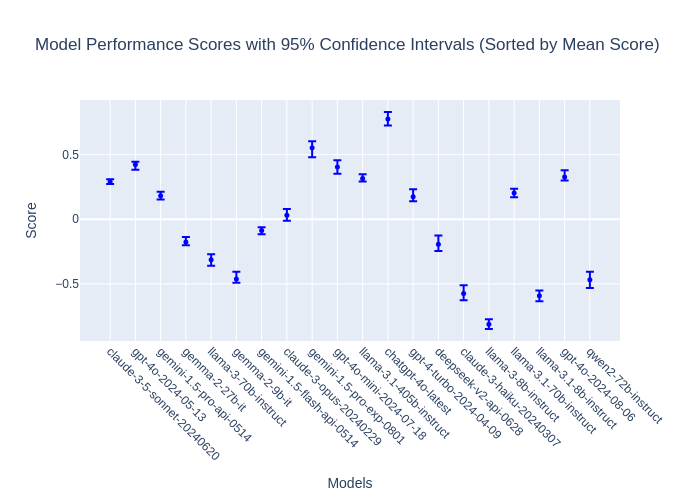

In [ ]:
results_df, mean_scores, confidence_intervals = get_bootstrapped_score(X, y, selected_models, n_bootstrap=10)
fig = go.Figure()

# Use the sorted values from results_df for plotting
fig.add_trace(go.Scatter(
    x=results_df["Model"],
    y=results_df["Average Score"],
    mode='markers',
    name='Model Scores',
    marker=dict(size=5, color='blue'),
    error_y=dict(
        type='data',
        array=results_df["Upper Bound"] - results_df["Average Score"],   # Upper error
        arrayminus=results_df["Average Score"] - results_df["Lower Bound"],  # Lower error
        visible=True
    )
))

fig.update_layout(
    title='Model Performance Scores with 95% Confidence Intervals (Sorted by Mean Score)',
    xaxis_title='Models',
    yaxis_title='Score',
    xaxis=dict(tickangle=45),
    height=500
)

fig.show()

## **Question 5b**

Now that we have confidence intervals, we can assign a rank to each model. We want the rank of model $i$ to represent the number of models that are **confidently better** than model $i$.

When we say model A is **confidently better** than model B, it will mean that model A's lower bound is still greater than model B's upper bound. Remember that greater rank means that there are more models that perform better than the current model.

**Task:**
Implement the `assign_rank` function below that assigns rank to the model.

In [ ]:
def assign_rank(row, df=results_df):
    """
    Input:
        row : pd.Series
            A row of the DataFrame (representing a model’s metrics).
        df : pd.DataFrame (default = results_df)
            DataFrame containing model performance with 'Lower Bound' and 'Upper Bound'.

    Output:
        int : The rank of the model, defined as (# of models confidently better) + 1.
    """

    count = sum(df["Lower Bound"] > row["Upper Bound"]) + 1
    return count


results_df['Rank'] = results_df.apply(lambda r: assign_rank(r, results_df), axis=1)
results_df = results_df.sort_values(by="Rank", ascending=True)
results_df

,Model,Average Score,Lower Bound,Upper Bound,Category,Rank
11,chatgpt-4o-latest,0.774987,0.726274,0.829740,Overall,1
8,gemini-1.5-pro-exp-0801,0.554146,0.480751,0.604371,Overall,2
1,gpt-4o-2024-05-13,0.423623,0.383834,0.445975,Overall,3
9,gpt-4o-mini-2024-07-18,0.403970,0.352319,0.457642,Overall,3
18,gpt-4o-2024-08-06,0.326661,0.299135,0.379301,Overall,4
10,llama-3.1-405b-instruct,0.314908,0.292626,0.348165,Overall,5
0,claude-3-5-sonnet-20240620,0.290515,0.273056,0.308921,Overall,5
2,gemini-1.5-pro-api-0514,0.181486,0.152365,0.213444,Overall,8
16,llama-3.1-70b-instruct,0.202466,0.170973,0.235124,Overall,8
12,gpt-4-turbo-2024-04-09,0.174749,0.138641,0.231269,Overall,8


In [ ]:
grader.check("q5b")

q5b results: All test cases passed!

Example (non-graded): visualize the leaderboard

Now that you have your leaderboard, let's use our premade `plot_rank_heatmap` in `plotting_utils.py` to visualize the results. This is an example cell and not a graded question.

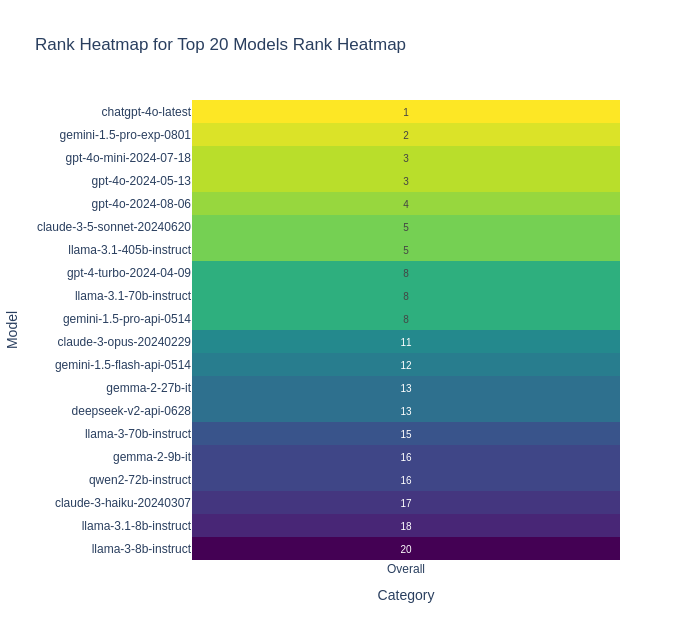

In [ ]:
# Example usage (for the current case: overall rank only)
category_names = ['Overall']
fig = plot_rank_heatmap(results_df)
fig.show()

> **NOTICE BEFORE YOUR PROGRESS**
> - If you accidentally modify `selected_battles_no_ties` in a way that breaks later parts, double check and **reset it** using the initial block of code you have placed.


# **Question 7: Ranking Influences**

One thing that has been known to affect user preference is response length: people (and LLM's) tend to prefer longer answers. A recurring observation in human grading and UX is that **longer responses are often preferred**. For example, analyses from the SAT essay reported that **essay length strongly correlated with higher scores—even when errors were present** ([New York Times, 2005](https://www.nytimes.com/2005/05/04/education/sat-essay-test-rewards-length-and-ignores-errors.html)).

In the context of LLM evaluations, this motivates a core question: **does response length systematically tilt battle outcomes and model rankings?**


Let's investigate whether length plays a role in model rankings. First let's do some quick analysis on the response length per model

## **Question 7a**

We want to analyze whether **response length (in tokens)** is related to model rankings.

In `per_model_battles` (which is what you would implement in Q7b), the **`conversation`** column contains, for each row, a *single exchange* between a user and a model (one battle). It is represented as a **list of message dictionaries**. These dictionaries are representing a full exchange between a user and a model in a single battle. The number of turns is `len(row['conversation']) // 2`.

**Each message dictionary contains (as provided):**
1. `"content"` – the text of the message  
3. `"role"` – either `"user"` or `"assistant"`. In our question we will be focusing on `"assistant"`

---

#### What exactly is `conv`?

For this question, assume your function will receive **`conv`**, which is a **dictionary** with a single key `"conversation"` mapping to a **list of message dictionaries**:

```python
conv_example = {
    "conversation": [
        {"role": "user", "content": "How do I sum a list in Python?"},
        {"role": "assistant", "content": "Use the built-in function: sum(your_list)."}
    ]
}
# conv_example["conversation"]  -> list of message dicts, ordered by turns
# Each dict has:
#   - "role": "user" or "assistant"
#   - "content": str (message text)


**Task:**
Implement a function `calculate_response_length` that, given a conversation `conv`, returns the total number of GPT-2 tokens in the concatenation of all **assistant messages** in that conversation.

**Requirements:**

1. Use the tiktoken library with the "gpt2" encoding. Import tiktoken.

2. Concatenate only the assistant messages and count tokens.

3. Call `enc.encode(..., disallowed_special=())` to allow all special tokens (avoids ValueError, e.g., for <|endoftext|>).

4. Concatenate all assistant role messages separated by two newlines ("\n\n") before counting tokens (join each them by this).

In [ ]:
import tiktoken
def calculate_response_length(conv):
    enc = tiktoken.encoding_for_model("gpt2")
    comment = ""
    for conversation in conv["conversation"]:
      if conversation["role"] == "assistant":
        comment = comment + " " + conversation["content"]
    return len(enc.encode(comment, disallowed_special = ()))

In [ ]:
grader.check("q7a")

q7a results: All test cases passed!

## **Question 7b**

In the previous question (Q7a), you wrote a function to compute the **token length** of a model's reply from a conversation. We’ll now **reshape** the battle-level data so that each row corresponds to a **single model’s response in a single battle** (instead of one row per battle).

In the `selected_battles_no_ties` DataFrame, each row represents a battle between two models, with:

*   conversation_a = the conversation for model_a in that battle
*   conversation_b = the conversation for model_b in that battle


To analyze response length per model, we would want a table where each row corresponds to a single model's response in a single battle (rather than one row per battle).

Specifically, our goal is to turn each battle row into **two rows** (tidy format):
1. one for `model_a` using `conversation_a`
2. one for `model_b` using `conversation_b`

**Task:**
Using the function defined in Question 7a, create a DataFrame named `per_model_battles ` with columns:

1. **`conversation`** — the list of message dicts for that model’s side of the battle  
2. **`model`** — the model name  
3. **`response_length`** — integer token count of all assistant messages concatenated (computed via **`calculate_response_length`** from Q7a)
> **Hint:** `pd.concat` might be handy for stacking the A-side and B-side tables into one.  
> Docs: https://pandas.pydata.org/docs/reference/api/pandas.concat.html

In [ ]:
#TODO:
battles_a = pd.DataFrame({"conversation" : list(selected_battles_no_ties.conversation_a),
                          "model" : list(selected_battles_no_ties.model_a)})
battles_b = pd.DataFrame({"conversation" : list(selected_battles_no_ties.conversation_b),
                          "model" : list(selected_battles_no_ties.model_b)})
per_model_battles = pd.concat([battles_a, battles_b], ignore_index = True)
per_model_battles["response_length"] = [calculate_response_length({"conversation" : list(conv)}) for conv in list(per_model_battles.conversation)]
per_model_battles.head()

,conversation,model,response_length
0,[{'content': 'Is there any Artificial Superint...,gemma-2-9b-it,362
1,[{'content': '有没有一些故事充斥着相互的矛盾和冲突，每个人都做出了自己认为正确...,gpt-4o-2024-08-06,1863
2,[{'content': 'チャットアプリのフロントエンドとバックエンドをそれぞれ作成して。...,gpt-4o-2024-05-13,1495
3,"[{'content': '其味无穷无', 'num_tokens': 7, 'role':...",gemma-2-27b-it,172
4,"[{'content': '1번글 옷은 단순히 물리적 보호를 넘어서, 우리의 정체성,...",claude-3-opus-20240229,2595


In [ ]:
grader.check("q7b")

q7b results: All test cases passed!

In [ ]:
# Let's take a look at the structure
print(per_model_battles['conversation'].iloc[0])

[{'content': 'Is there any Artificial Superintelligence?', 'num_tokens': 7, 'role': 'user'}
 {'content': "As a large language model, I am not able to provide an opinion or belief on whether or not artificial superintelligence exists. The concept of artificial superintelligence is a topic of much debate and speculation.\n\nHere's what we know:\n\n* **Current AI:** Today's AI, including myself, is very good at specific tasks, like generating text, translating languages, and playing games. However, we lack the general intelligence and common sense of humans.\n* **Superintelligence Definition:** Artificial superintelligence is generally defined as an AI that surpasses human intelligence in all aspects. This includes things like problem-solving, creativity, and learning.\n* **No Consensus:** There is no scientific consensus on whether or not artificial superintelligence is possible or even desirable. Some experts believe it is inevitable, while others believe it is highly unlikely or even d

Let's plot the response length for each model ordered by their rank and fit a trendline to see if there is any relation between rank and length.

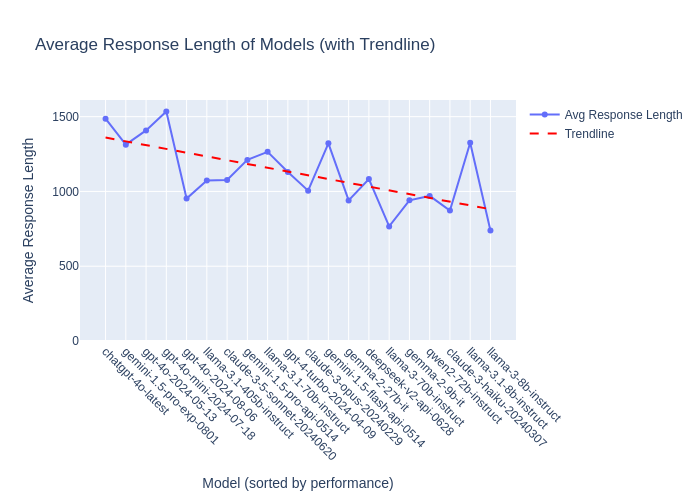

In [ ]:
model_lineup = results_df.sort_values("Rank")['Model'].tolist()
avg_lengths = per_model_battles.groupby("model")["response_length"].mean().reset_index()
avg_lengths["model"] = pd.Categorical(avg_lengths["model"], categories=model_lineup, ordered=True)
avg_lengths = avg_lengths.sort_values("model").reset_index(drop=True)

# Add a numeric rank column for trendline fitting
avg_lengths["rank"] = avg_lengths.index + 1  # 1 = best, etc.

# Fit a linear trendline (polyfit) to the response length vs. rank
z = np.polyfit(avg_lengths["rank"], avg_lengths["response_length"], 1)
p = np.poly1d(z)
trendline = p(avg_lengths["rank"])

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=avg_lengths["model"],
    y=avg_lengths["response_length"],
    mode='lines+markers',
    name='Avg Response Length'
))

fig.add_trace(go.Scatter(
    x=avg_lengths["model"],
    y=trendline,
    mode='lines',
    name='Trendline',
    line=dict(dash='dash', color='red')
))

fig.update_layout(
    title="Average Response Length of Models (with Trendline)",
    xaxis_title="Model (sorted by performance)",
    yaxis_title="Average Response Length",
    xaxis_tickangle=45,
    yaxis=dict(range=[0, max(avg_lengths["response_length"].max(), trendline.max()) * 1.05])  # y-axis starts at 0
)

fig.show()

# **Question 8: Style Control**

It looks like there is a trend: models with shorter responses tend to be ranked lower. While not a perfect analysis, if it could be true that people are preferring models which generate longer responses regardless of their other capabilities, then it would be useful to create a leaderboard which is *length agnostic*. Meaning, creating leaderboard model scores that control for certain stylistic properties of responses.

So how can we control for these stylistic factors in our model rankings?

In this question, you will implement a style feature ranking pipeline, starting with length as the only style feature.


1. Each row in `selected_battles_no_ties` represents a battle between model_a and model_b.

2. Each battle contains `conv_metadata` with pre-computed style metrics, such as bold text counts, header counts, list counts, and token counts for each side.

3. In the earlier question, each battle was converted to pairwise feature, where 1 denoted the model it belongs to, and -1 for the model that it was battling against. Now, our goal is to build on that data, including both the model identity indicators and the chosen style features.


## **Question 8a**

We want to add style features other than length that will give us style feature aware ranks.


**Task:**
Implement the function `add_style_features` that reads stylistic metrics from `conv_metadata` between each model (model_a, model_b) for count of bold, header, list, and assistant tokens. Then, store the normalized differences in columns (with the designated names):

1. style_bold_count
2. style_header_count
3. style_list_count
4. style_sum_assistant_tokens

The normalized differences would be following the formulation below:

$$
\text{normdiff}(a, b) =
\begin{cases}
0 & \text{if } a + b = 0 \\[6pt]
\dfrac{a - b}{a + b} & \text{otherwise}
\end{cases}
$$



Let's take a look at `conv_metadata`. Essentially, we will be stacking up these elements for each style count.

In [ ]:
selected_battles_no_ties['conv_metadata'].iloc[0]

{'bold_count_a': {'**': 5, '__': 0},
 'bold_count_b': {'**': 0, '__': 0},
 'context_a_tokens': 222,
 'context_b_tokens': 230,
 'header_count_a': {'h1': 0, 'h2': 0, 'h3': 0, 'h4': 0, 'h5': 0, 'h6': 0},
 'header_count_b': {'h1': 0, 'h2': 0, 'h3': 0, 'h4': 0, 'h5': 0, 'h6': 0},
 'list_count_a': {'ordered': 0, 'unordered': 5},
 'list_count_b': {'ordered': 0, 'unordered': 0},
 'sum_assistant_a_tokens': 335,
 'sum_assistant_b_tokens': 287,
 'sum_user_tokens': 14,
 'turns': 2}

In [ ]:
def add_style_features(df):
    """
    Adds normalized style feature difference columns to the DataFrame.
    The columns added are:
      - style_bold_count
      - style_header_count
      - style_list_count
      - style_sum_assistant_tokens
    """
    def normdiff(a, b):
        denom = a + b
        return 0 if denom == 0 else (a - b) / denom

    style_bold = []
    style_header = []
    style_list = []
    style_tokens = []

    for idx, row in df.iterrows():
        meta = row['conv_metadata']

        bold_a = sum(meta.get('bold_count_a', {}).values())
        bold_b = sum(meta.get('bold_count_b', {}).values())
        style_bold.append(normdiff(bold_a, bold_b))

        header_a = sum(meta.get('header_count_a', {}).values())
        header_b = sum(meta.get('header_count_b', {}).values())
        style_header.append(normdiff(header_a, header_b))

        list_a = sum(meta.get('list_count_a', {}).values())
        list_b = sum(meta.get('list_count_b', {}).values())
        style_list.append(normdiff(list_a, list_b))

        tokens_a = meta.get('sum_assistant_a_tokens', 0)
        tokens_b = meta.get('sum_assistant_b_tokens', 0)
        style_tokens.append(normdiff(tokens_a, tokens_b))

    df["style_bold_count"] = style_bold
    df["style_header_count"] = style_header
    df["style_list_count"] = style_list
    df["style_sum_assistant_tokens"] = style_tokens

    return df

# Example usage:
selected_battles_no_ties = add_style_features(selected_battles_no_ties)

In [ ]:
grader.check("q8a")

q8a results: All test cases passed!

<!-- BEGIN QUESTION -->

## **Question 8a Free Response Question**

We’ve now added stylistic features to each model comparison.  

**Answer the following question**

```otter
QUESTION: How can integrating these features into the ranking pipeline create the effect of a “length-controlled” leaderboard, and why might this adjustment be useful?  

Think about whether raw win/loss outcomes fully capture model quality, or whether stylistic inflation (e.g., longer answers, formatting tricks) can bias rankings.
```


YOUR ANSWER:

By integrating style features such as response length, bold usage, headers, or list counts into the ranking model, we can control for stylistic factors that might inflate user preference.
This creates a “length-controlled” leaderboard, where rankings reflect true content quality rather than superficial traits like longer or more formatted answers.

Such adjustment is useful because raw win/loss outcomes can be biased, models producing longer or more visually appealing responses may appear better even when their actual reasoning or factual accuracy is not.



<!-- END QUESTION -->

## **Question 8b**

Let's try to visualize and formulate the features we defined in the previous question in a neat way that we can see the direct relationship between the model battles and the style features.

We now want a training table where each battle produces two rows, one for each ordering of the competitors (A→B and B→A).
In other words, each row in the dataframe creates two entries in the new table.

**Task:**
Implement a function that creates the table described above. Each row should encode:
1. The model identity vector **X** (+1 at the selected model in the row, −1 at its opponent, 0 elsewhere)
2. The outcome y (win, lose)
3. Set of style covariates capturing A vs B normalized differences (e.g., length)

**NOTE:** Ensure that features are also antisymmetric, meaning they flipping the order of model should also flip the sign of each style feature.

Below is an example of the desired table.

| question_id                         | X                                           | y | direction | style_bold_count | style_header_count | style_list_count | style_sum_assistant_tokens |
|--------------------------------------|----------------------------------------------|---|-----------|------------------|--------------------|------------------|----------------------------|
| e8fe7c9f75ab4e528367cc7de625c475     | [0, 0, 0, 0, 0, 1, ...]  | 0 | A->B      | 1.0              | 0.0                | 1.0              | 0.07717                    |
| e8fe7c9f75ab4e528367cc7de625c475     | [0, 0, 0, 0, 0, -1 ...] | 1 | B->A      | -1.0             | -0.0               | -1.0             | -0.07717                   |


In [ ]:
def make_pairwise_feature_df(df, models, style_feature_cols):
    """
    For each row in df, create two rows in the output:
      - One for A->B (original direction)
      - One for B->A (flipped direction)
    Each row contains:
      - question_id
      - X: model indicator vector (1 for model_a, -1 for model_b, 0 otherwise)
      - y: 1 if model_a wins, 0 if model_b wins
      - style features (from style_feature_cols)
      - direction: "A->B" or "B->A"
    Returns a new DataFrame with only these columns.
    """

    model_to_idx = {model: idx for idx, model in enumerate(models)}

    records = []

    for idx, row in df.iterrows():
        question_id = row['question_id']
        model_a = row['model_a']
        model_b = row['model_b']
        winner = row['winner']

        x_a_to_b = [0] * len(models)
        x_a_to_b[model_to_idx[model_a]] = 1
        x_a_to_b[model_to_idx[model_b]] = -1

        x_b_to_a = [0] * len(models)
        x_b_to_a[model_to_idx[model_b]] = 1
        x_b_to_a[model_to_idx[model_a]] = -1

        y_a_to_b = 1 if winner == 'model_a' else 0
        y_b_to_a = 1 if winner == 'model_b' else 0

        style_features_a_to_b = {col: row[col] for col in style_feature_cols}
        style_features_b_to_a = {col: -row[col] for col in style_feature_cols}

        record_a_to_b = {
            'question_id': question_id,
            'X': x_a_to_b,
            'y': y_a_to_b,
            'direction': 'A->B'
        }
        record_a_to_b.update(style_features_a_to_b)
        records.append(record_a_to_b)

        record_b_to_a = {
            'question_id': question_id,
            'X': x_b_to_a,
            'y': y_b_to_a,
            'direction': 'B->A'
        }
        record_b_to_a.update(style_features_b_to_a)
        records.append(record_b_to_a)

    return pd.DataFrame(records)

style_feature_cols = [
    "style_bold_count",
    "style_header_count",
    "style_list_count",
    "style_sum_assistant_tokens"
]

pairwise_feature_df = make_pairwise_feature_df(selected_battles_no_ties, selected_models, style_feature_cols)
pairwise_feature_df.head(2)

,question_id,X,y,direction,style_bold_count,style_header_count,style_list_count,style_sum_assistant_tokens
0,e8fe7c9f75ab4e528367cc7de625c475,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,A->B,1.0,0.0,1.0,0.07717
1,e8fe7c9f75ab4e528367cc7de625c475,"[0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,B->A,-1.0,-0.0,-1.0,-0.07717


In [ ]:
grader.check("q8b")

q8b results: All test cases passed!

## **Question 8c**

Amazing! 🎉 Now that we've built our pairwise identity matrix X (which model is battling which) and our style feature matrix X_style (how A and B differ stylistically), let's combine these two so that our logistic model can learn:

1. The intrinsic strength of each model (controlling for style)
2. The influence of each style feature on the outcome

**Task:**
Now, implement the function `get_sc_category_results` that:
1. Stacks these two matrices into one design matrix X_with_style, so the model can learn both intrinsic model strengths and style effects simultaneously.
2. Uses `get_bootstrapped_score` to get the ranking results.
3. Returns the results sorted by rank in ascending order. All style features should be assigned a rank of -1

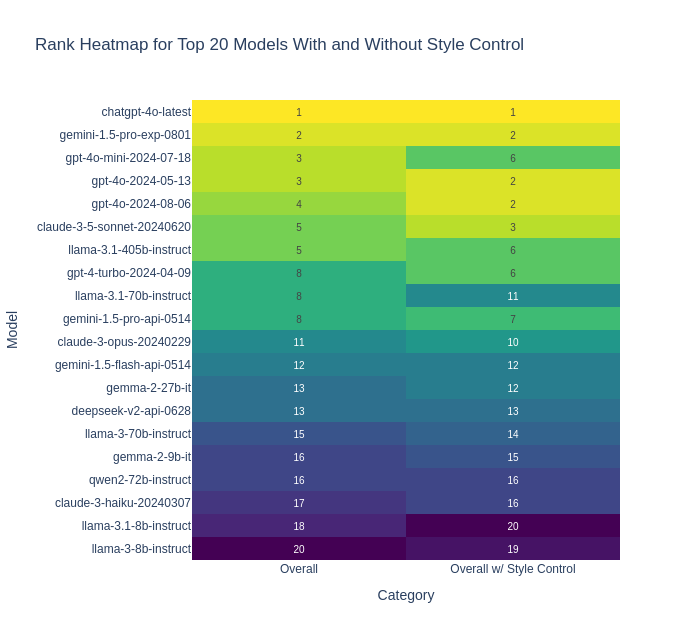

In [ ]:
def get_sc_category_results(df, selected_models, filter_mask = None, category_name="Overall w/ Style Control", n_bootstrap=10, style_features=style_feature_cols):
    #TODO
    feature_labels = selected_models + style_features
    if filter_mask != None:
      df = df[filter_mask].copy()

    pairwise_df = make_pairwise_feature_df(df, selected_models, style_features)
    X_identity = np.array(pairwise_df['X'].tolist())
    X_style = pairwise_df[style_features].values
    X_with_style = np.hstack([X_identity, X_style])

    y = pairwise_df['y'].values

    rank_df, mean_scores, confidence_intervals = get_bootstrapped_score(
        X_with_style,
        y,
        feature_labels,
        category_name,
        n_bootstrap
    )
    is_model = rank_df['Model'].isin(selected_models)

    model_results = rank_df[is_model].copy()
    style_results = rank_df[~is_model].copy()

    model_results['Rank'] = model_results.apply(lambda r: assign_rank(r, model_results), axis=1)

    style_results['Rank'] = -1

    rank_df = pd.concat([model_results, style_results], ignore_index=True)
    rank_df = rank_df[['Model', 'Category', 'Average Score', 'Lower Bound', 'Upper Bound', 'Rank']]

    return rank_df.sort_values(by="Rank", ascending=True)

results_df_style_control = get_sc_category_results(selected_battles_no_ties, selected_models, category_name="Overall w/ Style Control", n_bootstrap=10)
results_df = results_df[['Model', 'Category', 'Average Score', 'Lower Bound', 'Upper Bound', 'Rank']]
combined_results_df = pd.concat([results_df, results_df_style_control])
fig = plot_rank_heatmap(combined_results_df, title="With and Without Style Control")
fig.show()

In [ ]:
grader.check("q8c")

q8c results: All test cases passed!

### Look at the impact of style

Now let's visualize the style feature scores with confidence intervals using our premade `plot_style_features` in `plotting_utils.py`.

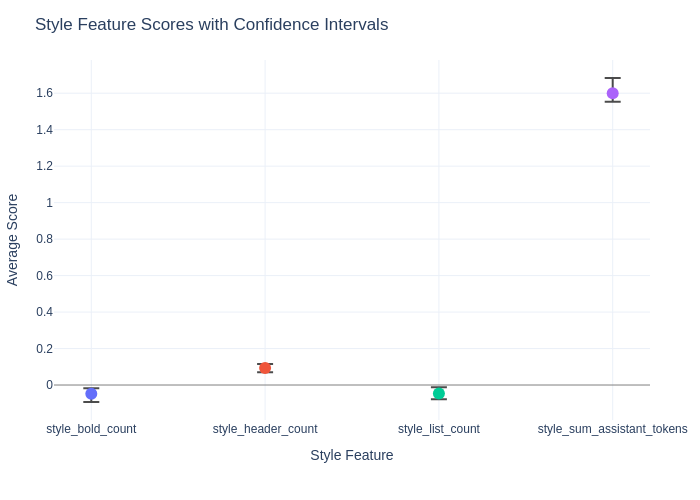

In [ ]:
# plot style feature coefficients
fig = plot_style_features(results_df_style_control, selected_models)
fig.show()

Here we see that length matters a LOT (in fact this coefficient is higher than the actual model coefficients), while things like bold and lists don't matter as much.

Here we can quickly see which models are "Style hacking" - formatting their responses nicely but not necessarily being more capable models. It looks like gpt-4o-mini and llama-3.1-70b-instruct see a consistent drop in rankings while models like claude 3.5 sonnet see a consistent rise in rankings.

# **Question 9: Finding New Style Influences**


Earlier, we saw how model preference differs by looking at structural style features in model outputs (e.g., bold text count, header count, list count, token length).
Now let's see if we can find new style features by inspecting the model responses to understand differences in models.
Let's inspect 🔍 the text ourselves for stylistic signals associated with wins. Your goal is to analyze assistant responses and identify phrases that differentiate winning from losing replies. This helps surface style features we might add to our ranking model later.

### Helper Functions
Function to turn a conversations into plain text:
*   convert_conversation_to_string
*   convert_asst_conversation_to_string

Function that compares two text with n-gram TF-IDF:
*   tfidf_phrase_diff

In [ ]:
def convert_conversation_to_string(conv):
  ret = ""
  for i in conv:
    if i['role'] == 'user':
      ret += "User: " + i['content'] + "\n\n"
    else:
      ret += "Assistant: " + i['content'] + "\n\n"
  return ret

def convert_asst_conversation_to_string(conv):
  ret = ""
  for i in conv:
    if i['role'] == 'assistant':
      ret += i['content'] + "\n\n"
  return ret

In [ ]:
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer

def is_number_phrase(phrase):
    # Remove phrases that are only numbers or contain only numbers and spaces/punctuation
    # Also remove phrases that are just a number or start/end with a number
    return bool(re.fullmatch(r"[\d\s\W]+", phrase)) or bool(re.search(r"\b\d+\b", phrase))

def tfidf_phrase_diff(str_list_a, str_list_b, name_a="A", name_b="B", top_n=30, max_features=1000):
    """
    Compute distinguishing ngram tfidf phrases between two sets of strings.
    Returns two DataFrames: one for phrases more common in A, one for B.
    """
    all_texts = str_list_a + str_list_b
    labels = [name_a] * len(str_list_a) + [name_b] * len(str_list_b)
    vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english', ngram_range=(2,4))
    tfidf_matrix = vectorizer.fit_transform(all_texts)
    feature_names = vectorizer.get_feature_names_out()
    n = len(str_list_a)
    tfidf_a = tfidf_matrix[:n]
    tfidf_b = tfidf_matrix[n:]
    mean_a = np.asarray(tfidf_a.mean(axis=0)).flatten()
    mean_b = np.asarray(tfidf_b.mean(axis=0)).flatten()
    # Top phrases for A
    a_scores = mean_a - mean_b
    top_a_indices = np.argsort(a_scores)[::-1]
    top_a_phrases = []
    for i in top_a_indices:
        phrase = feature_names[i]
        if not is_number_phrase(phrase):
            top_a_phrases.append((phrase, mean_a[i], mean_b[i]))
        if len(top_a_phrases) >= top_n:
            break
    # Top phrases for B
    b_scores = mean_b - mean_a
    top_b_indices = np.argsort(b_scores)[::-1]
    top_b_phrases = []
    for i in top_b_indices:
        phrase = feature_names[i]
        if not is_number_phrase(phrase):
            top_b_phrases.append((phrase, mean_b[i], mean_a[i]))
        if len(top_b_phrases) >= top_n:
            break
    df_a = pd.DataFrame(top_a_phrases, columns=["phrase", f"{name_a}_tfidf", f"{name_b}_tfidf"])
    df_b = pd.DataFrame(top_b_phrases, columns=["phrase", f"{name_b}_tfidf", f"{name_a}_tfidf"])
    return df_a, df_b

In [ ]:
# Example usage:
model = "llama-3.1-70b-instruct"
llama_battles = selected_battles_no_ties[
    ((selected_battles_no_ties['model_a'] == model) | (selected_battles_no_ties['model_b'] == model)) &
    (selected_battles_no_ties['language'] == 'English')
].copy()

llama_battles.loc[:, "model_a_conversation_string"] = llama_battles["conversation_a"].apply(convert_asst_conversation_to_string)
llama_battles.loc[:, "model_b_conversation_string"] = llama_battles["conversation_b"].apply(convert_asst_conversation_to_string)

str_list_a = llama_battles.apply(lambda x: x["model_a_conversation_string"] if x["model_a"] == model else x["model_b_conversation_string"], axis=1).tolist()
str_list_b = llama_battles.apply(lambda x: x["model_b_conversation_string"] if x["model_a"] == model else x["model_a_conversation_string"], axis=1).tolist()
# print(str_list_a)

df_a, df_b = tfidf_phrase_diff(str_list_a, str_list_b, model, "others")

print(f"Top {model} phrases:")
# display(df_a)
print(f"Top others phrases:")
# display(df_b)

Top llama-3.1-70b-instruct phrases:
Top others phrases:


# **Question 9a: Key Phrases**

Let's analyze which phrases inherent in the text might be related to the win or lose of the battles. This is a similar idea to VibeCheck except (1) instead of comparing model pairs we are comparing winning vs losing models and (2) instead of using LLMs to propose and validate vibes, we are going to be relying on keyword matching.

Using the helper functions provided (`convert_asst_conversation_to_string`, `tfidf_phrase_diff`) and the reference example as guidance, implement a winning-vs-losing phrase analysis for assistant responses.




**Task:**

1. From selected_battles_no_ties, keep only rows in English.

2. For each battle, extract assistant-only text using convert_asst_conversation_to_string.

3. Build winning_responses: one assistant-only string for the winning side of each battle.

4. Build losing_responses: one assistant-only string for the losing side of each battle.

5. Use tfidf_phrase_diff to compare the two lists and construct df_win and df_lose. (we have set this up for you)

6. Display the results to see the phrases most associated with winning vs. losing. (we have set this up for you)

For your reference, a sample subset of outputs is shown below.

### Example: Top phrases in *winning* responses
| phrase              | winning_tfidf | losing_tfidf |
|---------------------|---------------|--------------|
| let break           | 0.0127        | 0.0106       |
| step step           | 0.0146        | 0.0126       |\
| ... |...       | ...     |

### Example: Top phrases in *losing* responses
| phrase                 | losing_tfidf | winning_tfidf |
|------------------------|--------------|----------------|
| let know               | 0.0278       | 0.0190         |
| sorry assist           | 0.0054       | 0.0003         |
| ...     | ...      | ...  |


In [ ]:
# TFIDF comparing winning responses to losing responses

# 1) Restrict to English Only and prepare assistant-only strings for A/B
# Use 'convert_asst_conversation_to_string' helper function
selected_battles_english = selected_battles_no_ties[selected_battles_no_ties['language'] == 'English']
selected_battles_english['model_a_conversation_string'] = selected_battles_english['conversation_a'].apply(convert_asst_conversation_to_string)
selected_battles_english['model_b_conversation_string'] = selected_battles_english['conversation_b'].apply(convert_asst_conversation_to_string)


# 2) Build lists of assistant-only winning/losing responses
winning_responses = selected_battles_english.apply(
    lambda row: row['model_a_conversation_string'] if row['winner'] == 'model_a' else row['model_b_conversation_string'],
    axis=1
).tolist()

losing_responses = selected_battles_english.apply(
    lambda row: row['model_b_conversation_string'] if row['winner'] == 'model_a' else row['model_a_conversation_string'],
    axis=1
).tolist()

# 3) Compare phrases
df_win, df_lose = tfidf_phrase_diff(winning_responses, losing_responses, "winning", "losing")
# 4) Show results
print("Top winning response phrases:")
display(df_win)
print("Top losing response phrases:")
display(df_lose)

In [ ]:
grader.check("q9a")

q9a results: All test cases passed!

## Feature Exploration


New let's look at how we can add in a new style feature. Below we have an example of adding a `refusal_count` feature. Phrases like "i'm sorry" or "i apologize" appear more often in losing models - when looking through these conversations you will see that these are often instances of **refusal**: where the model refuses to answer the question because it violates ethical guidelines or is out of its domain of knowledge. Now let's turn this into a style feature to measure its impact on accuracy.


Let's try capturing whether the assistant on side A which apologizes more than side B in a battle by calculating the normalized sorry_count_diff. Here we will just have a binary 1/0 for each conversation indicating if it contains or does not contain the word "sorry" or "apologize".

In [ ]:
def count_phrase_diff(row, phrase=["step by step"]):
    step_by_step_a = False
    step_by_step_b = False
    for i in row["conversation_a"]:
        if i["role"] == "assistant" and any([p in i["content"].lower().replace("-", " ") for p in phrase]):
            step_by_step_a = True
    for i in row["conversation_b"]:
        if i["role"] == "assistant" and any([p in i["content"].lower().replace("-", " ") for p in phrase]):
            step_by_step_b = True
    return int(step_by_step_a) - int(step_by_step_b)


selected_battles_no_ties.loc[:, "refusal_count"] = selected_battles_no_ties.apply(
    lambda row: count_phrase_diff(row, ["sorry", "apologize"]),
    axis=1
)

<!-- BEGIN QUESTION -->

# **Question 9b: Discover Some Immaculate Vibes**

**Task:**
Now, just like the `refusal_count` feature we created above, implement new functions that can extract any stylistic features from the conversations.  
- Define a function that computes the normalized difference for a feature of your choice (e.g., presence of certain phrases, punctuation, formatting). You can check multiple different phrases if you want, they just to have a common "theme" - similar to the last problem of the previous part of this homework.   
- Apply this function to each row in the dataset.  
- Store the results in a new column of `selected_battles_no_ties["YOUR_FEATURE"]`.
- Plot the change in ranking and style coefficients and the existing style features along with your custom feature. **To get full points, your feature needs to get a higher magnitude coefficient [abs(Average Score)] than `style_header_count`**. It is okay if the confidence intervals overlap or if your coeffieinct is negative, as long as the absolute value is higher.
- You cannot use a feature already explored or anything similar (e.g. you can't have an "I refuse" style feature or a word count style feature).

This is open ended, you don't need to use the features you found above, get creative with it! Heck, you can even throw response pairs into your LLM of choice and ask it to come up with differences just like VibeCheck!

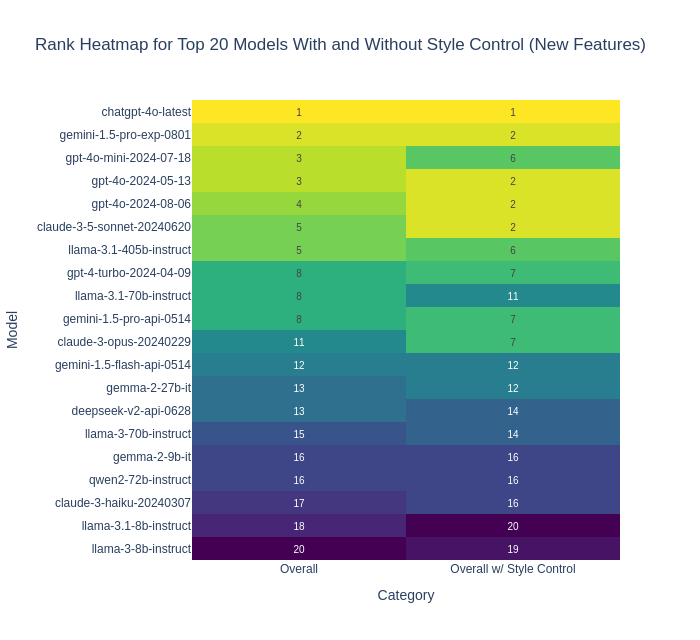

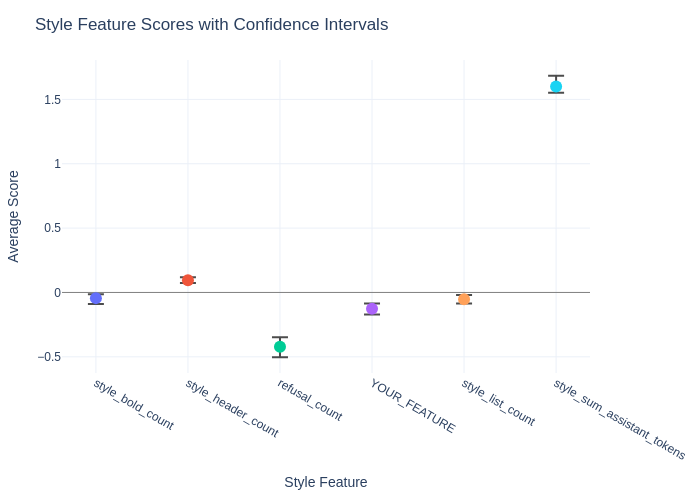

In [ ]:
# Design your own stylistic feature(s) that compare model A vs B on each row.
# Keep it simple (boolean presence, counts, or normalized differences) or get creative.

# Remember might want to normalize difference, if you compute counts

# TODO: Define your feature function
def YOUR_FUNC(row):
    #Input: a row with 'conversation_a' and 'conversation_b' (each is a list of {role, content} dicts).
    #Output: a single numeric feature comparing A vs B (e.g., -1/0/1, count diff, or normalized diff).
    #Hint: You probably want to inspect only assistant messages.
    # Example (placeholder): return 0
    keywords = [
        "i understand", "i can understand", "i see", "i can see", "i get",
        "sorry", "glad", "feel", "felt", "upset", "happy", "sad",
        "that sounds", "makes sense", "i can imagine", "i know how you feel"
    ]

    def normdiff(a, b):
      denom = a + b
      return 0 if denom == 0 else (a - b) / denom

    def count_style_empathy(row):
        count_a = 0
        count_b = 0
        for i in row["conversation_a"]:
            if i["role"] == "assistant":
              text = i.get("content", "")
              for pattern in keywords:
                count_a += len(re.findall(pattern, text, flags=re.MULTILINE))

        for i in row["conversation_b"]:
            if i["role"] == "assistant":
              text = i.get("content", "")
              for pattern in keywords:
                count_b += len(re.findall(pattern, text, flags=re.MULTILINE))

        return count_a, count_b


    # Count empathy cue occurrences for both models
    count_a, count_b = count_style_empathy(row)

    # Normalize the difference
    return normdiff(count_a, count_b)

# TODO: Apply your function to create a new column
selected_battles_no_ties.loc[:, "YOUR_FEATURE"] = selected_battles_no_ties.apply(YOUR_FUNC, axis=1)

# Choose which style features to control for in ranking.
# Start from this list and add yours below.
style_feature_cols = [
    "style_bold_count",
    "style_header_count",
    "style_list_count",
    "style_sum_assistant_tokens",
    "refusal_count",
    "YOUR_FEATURE"
]

combined_results_df_new = get_sc_category_results(selected_battles_no_ties,
                                 selected_models,
                                 category_name="Overall w/ Style Control",
                                 n_bootstrap=10,
                                 style_features=style_feature_cols)

fig = plot_rank_heatmap(pd.concat([results_df, combined_results_df_new]), title="With and Without Style Control (New Features)", selected_models=selected_models)
fig.show()

# Create and display the plot
fig = plot_style_features(combined_results_df_new, selected_models)
fig.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

# **Question 9c: Reflection**

**Answer the following questions**

```otter
9c-1. Why did you decide to use the stylistic feature that you have implemented for Q9b? What ranking changes across models did you see when looking at the new style features you created? Why do you think that is the case?

9c-2. Why might some models overuse or underuse stylistic markers (e.g., exclamation points, apologies, or explicit reasoning phrases), and how could that influence rankings?

9c-3. How does including these stylistic features help control for length or formatting effects when building leaderboards?
```


YOUR ANSWER 9c-1:

I chose the empathy feature because some models (such as GPT-4o) tend to produce more empathetic responses compared to others. After controlling for this feature, I observed that the rankings of models like GPT-4o-mini and LLaMA-based models slightly decreased, while interestingly, the Claude-3-Opus model performed better.

YOUR ANSWER 9c-2:

Similar to what is discussed in the VibeCheck paper, regardless of how accurate a model is, certain styles or “vibes” in responses are often preferred by users. Many models are fine-tuned to align with these preferences to increase user satisfaction. As a result, leaderboard rankings can be influenced by stylistic traits rather than true accuracy or reasoning ability, which may inflate a model’s apparent performance.

YOUR ANSWER 9c-3:

By including stylistic features such as formatting, empathy, or punctuation usage in the regression model, we can statistically control for the effect of style on win rates. This adjustment ensures that models are ranked for their content quality rather than superficial traits like longer answers, excessive markdown, or friendlier tone. In other words, it creates a length and style controlled leaderboard, where scores reflect substantive performance rather than presentation bias.


<!-- END QUESTION -->



## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
## Use this cell if you are running the notebook in Google Colab to install the necessary dependencies, this may take a few minutes
if IS_COLAB:
    !apt-get install -y texlive texlive-xetex pandoc


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)

Running your submission against local test cases...


Your submission received the following results when run against available test cases:

    q4a results: All test cases passed!

    q4b results: All test cases passed!

    q5a results: All test cases passed!

    q5b results: All test cases passed!

    q7a results: All test cases passed!

    q7b results: All test cases passed!

    q8a results: All test cases passed!

    q8b results: All test cases passed!

    q8c results: All test cases passed!

    q9a results: All test cases passed!
